# Transformer based Korean-English Machine Translation

- Paper: [Attention Is All You Need](https://arxiv.org/abs/1706.03762)
- 참고자료: [blog](https://brunch.co.kr/@leadbreak/11), [github](https://github.com/leadbreak/study/blob/main/algorithm/02.transformer_intermediate/02.transformer_intermediate.ipynb)
- 데이터셋 출처: [AIHuB](https://aihub.or.kr/aihubdata/data/view.do?currMenu=115&topMenu=100&aihubDataSe=realm&dataSetSn=126)

# Prework

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

!pip install transformers
!pip install sentencepiece # MarianTokenizer 불러올 때 필요
!pip install sacremoses # MarianMTModel 에서 불러올 때 warning 뜨는 것 방지

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 18 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 1s (9,962 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 124950 files and dire

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
dir = "/content/drive/MyDrive/Colab Notebooks/git/implementation/DL/Transformer"
data_dir = dir + "/data"
model_dir = dir + "/model"
result_dir = dir + "/result"

train_file = data_dir + "/train1.xlsx"

### Konlpy 설치...는 안 함.

In [ ]:
# %%bash
# apt-get update
# apt-get install g++ openjdk-8-jdk
# pip3 install JPype1
# pip3 install konlpy

In [ ]:
# %env JAVA_HOME "/usr/lib/jvm/java-8-openjdk-amd64"

In [ ]:
# !curl -s https://raw.githubusercontent.com/teddylee777/machine-learning/master/99-Misc/01-Colab/mecab-colab.sh | bash

In [ ]:
# 사전을 수동설치하라는데 걍 안 쓰고 말지
# from konlpy.tag import Mecab
# mecab = Mecab()
# pprint(mecab.pos(u'위에서 Mecab을 설치하셨으면 이 코드를 실행하실 수 있어요!'))

In [ ]:
# import konlpy
# from konlpy.tag import Kkma, Komoran, Hannanum, Okt
# from konlpy.utils import pprint
# kkma = Kkma()
# komoran = Komoran()
# hannanum = Hannanum()
# okt = Okt()
# pprint(kkma.sentences(u'네, 안녕하세요. 반갑습니다.'))
# pprint(komoran.nouns(u'질문이나 건의사항은 깃헙 이슈 트래커에 남겨주세요.'))
# pprint(hannanum.pos(u'오류보고는 실행환경, 에러메세지와함께 설명을 최대한상세히!^^'))
# pprint(okt.phrases(u'구글은 멋져요. 깃허브도 멋져요. KoNLPy도 멋져요!'))

# Load libraries

In [ ]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim import Adam
import torch.nn.functional as F

from transformers import MarianMTModel, MarianTokenizer

import math
import time
from tqdm import tqdm

# Load Data

In [ ]:
total_df = pd.read_excel(train_file)
print(len(total_df))

200011


In [ ]:
total_df.head()

,ID,날짜,자동분류1,자동분류2,자동분류3,URL,언론사,원문,번역문
0,20961563,2018-10-01 00:00:00,"경제,국제경제","IT_과학,IT_과학일반","문화,문화일반",http://www.sedaily.com/NewsView/1S5QRSR5T2,서울경제,스키너가 말한 보상은 대부분 눈으로 볼 수 있는 현물이다.,Skinner's reward is mostly eye-watering.
1,20930897,2018-09-14 00:00:00,"IT_과학,IT_과학일반",NaN,NaN,http://www.sedaily.com/NewsView/1S4MSFM0IH,서울경제,심지어 어떤 문제가 발생할 건지도 어느 정도 예측이 가능하다.,Even some problems can be predicted.
2,20307875,2019-04-19 00:00:00,"IT_과학,과학",NaN,NaN,http://news.kmib.co.kr/article/view.asp?arcid=...,국민일보,오직 하나님만이 그 이유를 제대로 알 수 있을 겁니다.,Only God will exactly know why.
3,20314977,2019-04-27 00:00:00,"국제,중국","경제,국제경제",NaN,http://news.kmib.co.kr/article/view.asp?arcid=...,국민일보,중국의 논쟁을 보며 간과해선 안 될 게 기업들의 고충이다.,Businesses should not overlook China's dispute.
4,20268904,2019-03-13 00:00:00,"문화,방송_연예","사회,미디어",NaN,http://news.kmib.co.kr/article/view.asp?arcid=...,국민일보,박자가 느린 노래는 오랜 시간이 지나 뜨는 경우가 있다.,Slow-beating songs often float over time.


# Customize Datasets

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, data: pd.DataFrame):
        super().__init__()
        self.data = data

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        return self.data.loc[idx, "원문"], self.data.loc[idx, "번역문"]

In [ ]:
tr_size = 10_000
val_size = int(tr_size * 0.1)
test_size = val_size
total_size = tr_size + val_size + test_size

total_df = total_df[:total_size]
total_ds = CustomDataset(total_df)

print(len(total_ds))
print(total_ds[0])

tr_ds, val_ds, test_ds = random_split(total_ds, [tr_size, val_size, test_size])

print(len(tr_ds))
print(len(val_ds))
print(len(test_ds))

12000
('스키너가 말한 보상은 대부분 눈으로 볼 수 있는 현물이다.', "Skinner's reward is mostly eye-watering.")
10000
1000
1000


# Load Tokenizer



In [ ]:
tokenizer = MarianTokenizer.from_pretrained("Helsinki-NLP/opus-mt-ko-en")

eos_idx = tokenizer.eos_token_id
pad_idx = tokenizer.pad_token_id
print("eos_idx = ", eos_idx)
print("pad_idx = ", pad_idx)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/44.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/842k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/813k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.72M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.39k [00:00<?, ?B/s]

eos_idx =  0
pad_idx =  65000


In [ ]:
vocab_size = tokenizer.vocab_size
print("vocab size:", vocab_size)

vocab size: 65001


In [ ]:
text = "원본 데이터의 클래스 비율이 8:2라면 분리된 train data, valid(test) data의 클래스 비율도 8:2가 유지됩니다."
print("Original text:", text)
print(tokenizer.tokenize(text))

Original text: 원본 데이터의 클래스 비율이 8:2라면 분리된 train data, valid(test) data의 클래스 비율도 8:2가 유지됩니다.
['▁원본', '▁데이터', '의', '▁클래스', '▁비율', '이', '▁8:', '2', '라면', '▁분리', '된', '▁', 'tra', 'in', '▁d', 'ata', ',', '▁v', 'al', 'id', '(', 't', 'est', ')', '▁d', 'ata', '의', '▁클래스', '▁비율', '도', '▁8:', '2', '가', '▁유지', '됩니다', '.']


In [ ]:
text = "위와 같은 데이터 분리를 하게 되면 모델 검증을 통해 모델의 예측에 있어 과적합을 방지할 수 있습니다."
print("Original text:", text)
print(tokenizer.tokenize(text))

Original text: 위와 같은 데이터 분리를 하게 되면 모델 검증을 통해 모델의 예측에 있어 과적합을 방지할 수 있습니다.
['▁위', '와', '▁같은', '▁데이터', '▁분리', '를', '▁하게', '▁되면', '▁모델', '▁검증', '을', '▁통해', '▁모델', '의', '▁예측', '에', '▁있어', '▁과', '적합', '을', '▁', '방지', '할', '▁수', '▁있습니다', '.']


In [ ]:
encoded = tokenizer.encode(text)
non_special_encoded = tokenizer.encode(text, add_special_tokens=False)

decoded = tokenizer.decode(encoded)
non_special_decoded = tokenizer.decode(non_special_encoded)

print("encoded:", encoded)
print("special encoded:", non_special_encoded)

print("decoded:", decoded)
print("special decoded:", non_special_decoded)

encoded: [2070, 195, 532, 7536, 12774, 79, 244, 3256, 10080, 39072, 51, 3030, 10080, 53, 17368, 64, 480, 88, 12765, 51, 9, 9435, 251, 103, 264, 2, 0]
special encoded: [2070, 195, 532, 7536, 12774, 79, 244, 3256, 10080, 39072, 51, 3030, 10080, 53, 17368, 64, 480, 88, 12765, 51, 9, 9435, 251, 103, 264, 2]
decoded: 위와 같은 데이터 분리를 하게 되면 모델 검증을 통해 모델의 예측에 있어 과적합을 방지할 수 있습니다.</s>
special decoded: 위와 같은 데이터 분리를 하게 되면 모델 검증을 통해 모델의 예측에 있어 과적합을 방지할 수 있습니다.


In [ ]:
print(tokenizer.decode([2070]))

위


In [ ]:
text = "Businesses should not overlook China's dispute."
encoded = tokenizer.encode(text)
tokenized = tokenizer.tokenize(text)
decoded = tokenizer.decode(encoded)

print("Original:", text)
print("Encoded:", encoded)
print("Tokenized:", tokenized)
print("Decoded:", decoded)

Original: Businesses should not overlook China's dispute.
Encoded: [505, 1619, 494, 10705, 833, 979, 5732, 2021, 173, 34, 9, 8513, 1053, 11503, 11059, 494, 293, 12, 10, 9, 5566, 23269, 14542, 2, 0]
Tokenized: ['▁B', 'us', 'in', 'ess', 'es', '▁s', 'ho', 'ul', 'd', '▁not', '▁', 'over', 'l', 'ook', '▁Ch', 'in', 'a', "'", 's', '▁', 'di', 'sp', 'ute', '.']
Decoded: Businesses should not overlook China's dispute.</s>


# Transformer Implementation

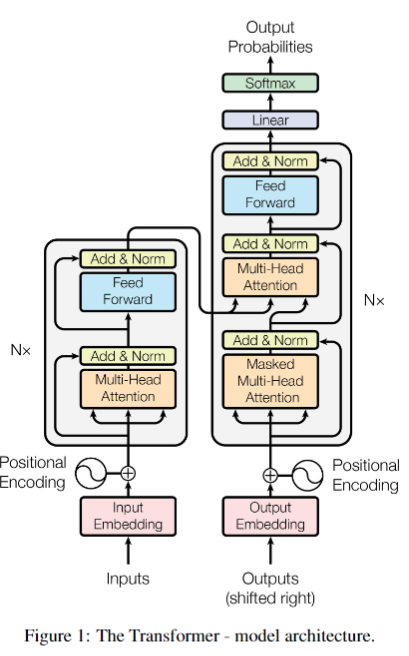

## Layers

### Embedding
- Transformer class에서 nn.Embedding 모듈 사용하면 끝.
- 논문에 따르면, input_embedding, output_embedding 모두 동일한 weight matrix를 사용함. ([근거](https://arxiv.org/abs/1608.05859), [요약본](https://gbdai.tistory.com/48))

### Positional Encoding
- 본 논문에서는 sin, cos 함수를 이용한 sinusoidal positional encoding 적용
- ViT에서는 positional embedding 적용. 즉, position에 대한 weight를 직접 학습.
- 둘 다 성능에 뚜렷한 차이는 안 보인다.
- sinusoidal PE는 seq_len이 길어져도 extrapolate가 가능하다는 근거로 채택됨.

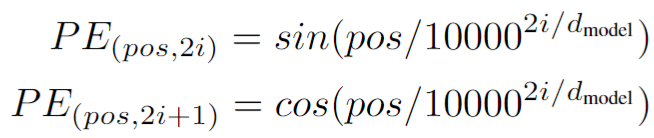

- PE를 input embedding에 더함.
- PE matrix와 input embedding은 같은 차원.
- pos는 position, i는 dimension

In [ ]:
def positional_encoding(shape: torch.Size, device: str|torch.device):
    '''
    :Args:
        :shape: positional encoding을 적용할 tensor의 shape. shape = (batch_size, N, dim)
        :device: 사용하는 장치 (cpu | cuda)
    :Return:
        :pos_enc: shape에 맞는 positional encoding table
    '''
    n = shape[1]
    d_model = shape[2]

    position = torch.arange(n).to(device).unsqueeze(1)
    pos_enc = torch.zeros(shape[1:]).to(device)
    _2i = torch.arange(0, d_model, 2).to(device)
    div_term = torch.exp(_2i / d_model * math.log(10000.0))

    pos_enc[:, 0::2] = torch.sin(position * div_term)
    pos_enc[:, 1::2] = torch.cos(position * div_term)

    return pos_enc

In [ ]:
a = torch.ones(3, 5, 4)
b = positional_encoding(a.size(), "cpu")
a + b

tensor([[[1.0000e+00, 2.0000e+00, 1.0000e+00, 2.0000e+00],
         [1.8415e+00, 1.5403e+00, 4.9364e-01, 1.8623e+00],
         [1.9093e+00, 5.8385e-01, 1.2671e-01, 1.4872e+00],
         [1.1411e+00, 1.0008e-02, 2.4348e-04, 9.7793e-01],
         [2.4320e-01, 3.4636e-01, 1.4906e-01, 4.7473e-01]],

        [[1.0000e+00, 2.0000e+00, 1.0000e+00, 2.0000e+00],
         [1.8415e+00, 1.5403e+00, 4.9364e-01, 1.8623e+00],
         [1.9093e+00, 5.8385e-01, 1.2671e-01, 1.4872e+00],
         [1.1411e+00, 1.0008e-02, 2.4348e-04, 9.7793e-01],
         [2.4320e-01, 3.4636e-01, 1.4906e-01, 4.7473e-01]],

        [[1.0000e+00, 2.0000e+00, 1.0000e+00, 2.0000e+00],
         [1.8415e+00, 1.5403e+00, 4.9364e-01, 1.8623e+00],
         [1.9093e+00, 5.8385e-01, 1.2671e-01, 1.4872e+00],
         [1.1411e+00, 1.0008e-02, 2.4348e-04, 9.7793e-01],
         [2.4320e-01, 3.4636e-01, 1.4906e-01, 4.7473e-01]]])

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, max_len: int, device: torch.device):
        '''
        Sinusoidal positional encoding을 적용하는 모듈
        :d_model: 모델이 사용할 임베딩 dimension
        :max_len: sequence의 최대 길이
        :device: cpu | cuda -> 사용하는 device.
        '''

        super().__init__()
        self.pe = torch.zeros((max_len, d_model), device=device)
        self.register_buffer("pos_enc_table", self.pe)

        position = torch.arange(max_len, device=device).unsqueeze(1)
        _2i = torch.arange(0, d_model, 2).to(device)
        div_term = torch.exp(_2i / d_model * math.log(10000.0))

        self.pe[:, 0::2] = torch.sin(position * div_term)
        self.pe[:, 1::2] = torch.cos(position * div_term)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        '''
        :Args:
            :x: torch.tensor, shape == (batch_size, N, d_model)
        :Return:
            x에 postional encoding 값을 더한 결과
        '''
        seq_len = x.shape[1]
        return x + self.pe[:seq_len, :]

In [ ]:
a = torch.ones(3, 5, 4)
b = PositionalEncoding(a.shape[-1], 100, "cpu")
print(a)
print(b.pe[:5])
print(b(a))

tensor([[[1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.]],

        [[1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.]],

        [[1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.]]])
tensor([[ 0.0000,  1.0000,  0.0000,  1.0000],
        [ 0.8415,  0.5403, -0.5064,  0.8623],
        [ 0.9093, -0.4161, -0.8733,  0.4872],
        [ 0.1411, -0.9900, -0.9998, -0.0221],
        [-0.7568, -0.6536, -0.8509, -0.5253]])
tensor([[[1.0000e+00, 2.0000e+00, 1.0000e+00, 2.0000e+00],
         [1.8415e+00, 1.5403e+00, 4.9364e-01, 1.8623e+00],
         [1.9093e+00, 5.8385e-01, 1.2671e-01, 1.4872e+00],
         [1.1411e+00, 1.0008e-02, 2.4348e-04, 9.7793e-01],
         [2.4320e-01, 3.4636e-01, 1.4906e-01, 4.7473e-01]],

        [[1.0000e+00, 2.0000e+00, 1.0000e+00, 2.0000e+00],
  

### Scaled Dot-Product Attention

In [ ]:
class ScaledDotProductAttention(nn.Module):
    '''
    Scaled dot product attention을 계산하는 모듈
    :Attributes:
        :d_k: key의 dimension
    '''
    def __init__(self, d_k: int):
        '''
        :Args:
            :d_k: key의 dimension
        '''
        super().__init__()
        self.scale = 1 / math.sqrt(d_k)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, q: torch.Tensor, k: torch.Tensor, v: torch.Tensor, mask=None) -> torch.Tensor:
        '''
        Scaled dot-product attention을 계산한다.
        1. q와 k의 dot product 계산
        2. scale 곱해줌 (scale = 1 / sqrt(d_k))
        3. mask가 있다면, mask 곱해줌
        4. softmax 함수 적용
        5. v와 dot product 계산
        :Args:
            :q: Attention query
            :k: Attention key
            :v: Attention value
        :Return:
            :attn: Attention을 계산한 결과 (shape = (batch_size, ..., d_v))
        '''
        qk = torch.matmul(q, k.transpose(-1, -2)) * self.scale
        if mask is not None:
            qk = qk.masked_fill(mask, -1e9)
        attn_matrix = self.softmax(qk)
        attn = torch.matmul(attn_matrix, v)
        return attn

In [ ]:
attention_module = ScaledDotProductAttention(10)
q = torch.ones((2, 2, 5, 10))
k = torch.ones((2, 2, 5, 10))
v = torch.ones((2, 2, 5, 10))
attention_module(q, k, v)

tensor([[[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]],

         [[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]],


        [[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]],

         [[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
    

### MHA

In [ ]:
class MultiHeadAttention(nn.Module):
    '''
    MultiHeadAttention을 계산하는 모듈
    '''
    def __init__(self, d_model: int, num_head: int, d_k: int, d_v: int):
        '''
        :Args:
            :d_model: MHA에 입력되는 tensor들의 dimension
            :num_head: MHA에서 사용할 head 갯수.
            :d_k: key의 dimension
            :d_v: value의 dimension
        '''
        super().__init__()

        self.num_head = num_head
        self.d_k = d_k
        self.d_v = d_v

        self.q = nn.Linear(d_model, d_k)
        self.k = nn.Linear(d_model, d_k)
        self.v = nn.Linear(d_model, d_v)

        self.attn = ScaledDotProductAttention(d_k // num_head)
        self.linear = nn.Linear(d_v, d_model)

    def forward(self, query: torch.Tensor, key: torch.Tensor, value: torch.Tensor, mask=None) -> torch.Tensor:
        '''
        MultiHeadAttention을 계산한다.
        1. query, key, value를 각각 d_k, d_k, d_v 차원으로 linear projection 진행
        2. 각각을 num_head만큼 분할
        3. ScaledDotProductAttention 계산
        4. 분할되었던 tensor를 concat
        5. d_model 차원으로 linear projection 진행
        :Args:
            :query: MHA Query
            :key: MHA Key
            :value: MHA value
            :mask: (Optional) MHA mak
        :Return:
            :ret: MHA의 결과 (shape = (batch_size, n, d_model))
        '''
        batch_size = query.shape[0]

        q = self.q(query)
        k = self.k(key)
        v = self.v(value)

        q = q.reshape(batch_size, -1, self.num_head, self.d_k // self.num_head).permute(0, 2, 1, 3)
        k = k.reshape(batch_size, -1, self.num_head, self.d_k // self.num_head).permute(0, 2, 1, 3)
        v = v.reshape(batch_size, -1, self.num_head, self.d_v // self.num_head).permute(0, 2, 1, 3)

        attn = self.attn(q, k, v, mask)
        attn = attn.permute(0, 2, 1, 3).reshape(batch_size, -1, self.d_v)

        ret = self.linear(attn)

        return ret

In [ ]:
d_model = 16
num_head = 4
d_k = 8
d_v = 8

mha = MultiHeadAttention(d_model, num_head, d_k, d_v)

q = torch.ones((2, 12, d_model))
k = torch.ones((2, 12, d_model))
v = torch.ones((2, 12, d_model))

ret = mha(q, k, v)
print(ret.shape)
print(ret)

torch.Size([2, 12, 16])
tensor([[[-0.0823,  0.2195,  0.2191, -0.3985, -0.2362, -0.6870,  0.0395,
          -0.4102,  0.1464,  0.0798, -0.2107,  0.2229,  0.3745,  0.0136,
          -0.1130, -0.3738],
         [-0.0823,  0.2195,  0.2191, -0.3985, -0.2362, -0.6870,  0.0395,
          -0.4102,  0.1464,  0.0798, -0.2107,  0.2229,  0.3745,  0.0136,
          -0.1130, -0.3738],
         [-0.0823,  0.2195,  0.2191, -0.3985, -0.2362, -0.6870,  0.0395,
          -0.4102,  0.1464,  0.0798, -0.2107,  0.2229,  0.3745,  0.0136,
          -0.1130, -0.3738],
         [-0.0823,  0.2195,  0.2191, -0.3985, -0.2362, -0.6870,  0.0395,
          -0.4102,  0.1464,  0.0798, -0.2107,  0.2229,  0.3745,  0.0136,
          -0.1130, -0.3738],
         [-0.0823,  0.2195,  0.2191, -0.3985, -0.2362, -0.6870,  0.0395,
          -0.4102,  0.1464,  0.0798, -0.2107,  0.2229,  0.3745,  0.0136,
          -0.1130, -0.3738],
         [-0.0823,  0.2195,  0.2191, -0.3985, -0.2362, -0.6870,  0.0395,
          -0.4102,  0.1464, 

### FeedForward Network

$$FFN(x) = \max(0, xW_1 + b_1)W_2 + b_2$$

- $W_1$: $d_{model} \times d_{ff}$ matrix
- $W_2$: $d_{ff} \times d_{model}$ matrix

In [ ]:
class FeedForwardNet(nn.Module):
    def __init__(self, d_model, d_ff):
        super().__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)
        self.activation = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.linear1(x)
        x = self.activation(x)
        x = self.linear2(x)
        return x

In [ ]:
d_model = 4
d_ff = 16

ffn = FeedForwardNet(d_model, d_ff)
x = torch.ones((2, 5, d_model))
print(ffn(x))

tensor([[[-0.2392,  0.0677,  0.2155,  0.4389],
         [-0.2392,  0.0677,  0.2155,  0.4389],
         [-0.2392,  0.0677,  0.2155,  0.4389],
         [-0.2392,  0.0677,  0.2155,  0.4389],
         [-0.2392,  0.0677,  0.2155,  0.4389]],

        [[-0.2392,  0.0677,  0.2155,  0.4389],
         [-0.2392,  0.0677,  0.2155,  0.4389],
         [-0.2392,  0.0677,  0.2155,  0.4389],
         [-0.2392,  0.0677,  0.2155,  0.4389],
         [-0.2392,  0.0677,  0.2155,  0.4389]]], grad_fn=<ViewBackward0>)


## Blocks

### Encoder

In [ ]:
class EncoderBlock(nn.Module):
    def __init__(self, d_model, num_head, d_k, d_v, d_ff, dropout=0.1):
        super().__init__()
        self.attn = MultiHeadAttention(d_model, num_head, d_k, d_v)
        self.ffn = FeedForwardNet(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        identity = x
        x = self.attn(x, x, x, mask)
        x = self.dropout(x) + identity
        x = self.norm1(x)

        identity = x
        x = self.ffn(x)
        x = self.dropout(x) + identity
        x = self.norm2(x)

        return x

In [ ]:
class Encoder(nn.Module):
    def __init__(self, num_block, d_model, num_head, d_k, d_v, d_ff, dropout=0.1):
        super().__init__()
        self.blocks = nn.ModuleList([EncoderBlock(d_model, num_head, d_k, d_v, d_ff, dropout) for _ in range(num_block)])

    def forward(self, x, mask=None):
        for block in self.blocks:
            x = block(x, mask)
        return x

In [ ]:
num_block = 4
d_model =32
num_head = 2
d_k = 16
d_v = 16
d_ff = 16

encoder = Encoder(num_block, d_model, num_head, d_k, d_v, d_ff)
a = torch.ones((2, 3, d_model))
ret = encoder(a)
print(ret.shape)
print(ret)

torch.Size([2, 3, 32])
tensor([[[ 1.8609e+00,  4.4397e-01,  9.9249e-01, -1.9187e+00,  4.6878e-01,
          -2.0965e-01,  1.3751e+00,  1.6131e+00, -2.1205e+00, -4.7201e-01,
          -1.5254e+00,  9.1428e-01, -4.3530e-01,  1.9316e-01,  7.5302e-01,
           6.6412e-01, -4.9274e-01,  6.8275e-01,  3.2627e-01,  7.7677e-01,
          -2.5718e-02, -1.7513e-01,  1.2884e+00, -6.7676e-01, -1.0598e+00,
          -7.5500e-02, -1.6711e+00, -1.1323e+00, -7.3378e-01, -1.1024e-01,
           6.6558e-01, -1.8398e-01],
         [ 1.8533e+00,  4.0867e-01,  8.2610e-01, -2.0702e+00,  2.6436e-01,
           1.6821e-01,  1.9003e+00,  1.7437e-01, -2.1390e+00, -4.6096e-01,
          -1.4025e+00,  1.5694e+00, -4.3029e-01,  4.9691e-01,  1.2943e+00,
           5.2220e-01, -3.4716e-01,  4.1623e-01,  6.6733e-01,  1.0942e+00,
           4.3313e-03, -3.8132e-01,  8.3817e-01, -5.2495e-01, -9.3514e-01,
          -1.1026e-01, -1.5462e+00, -1.0482e+00, -7.5295e-01,  6.3529e-02,
          -2.0353e-01, -2.0904e-01],
   

### Decoder

In [ ]:
class DecoderBlock(nn.Module):
    def __init__(self, d_model, num_head, d_k, d_v, d_ff, dropout=0.1):
        super().__init__()
        self.self_attn = MultiHeadAttention(d_model, num_head, d_k, d_v)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_head, d_k, d_v)
        self.ffn = FeedForwardNet(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, enc_feat, dec_mask, enc_dec_mask):
        identity = x
        x = self.self_attn(x, x, x, dec_mask)
        x = self.dropout(x) + identity
        x = self.norm1(x)

        identity = x
        x = self.enc_dec_attn(x, enc_feat, enc_feat, enc_dec_mask)
        x = self.dropout(x) + identity
        x = self.norm2(x)

        identity = x
        x = self.ffn(x)
        x = self.dropout(x) + identity
        x = self.norm3(x)

        return x

In [ ]:
class Decoder(nn.Module):
    def __init__(self, num_block, d_model, num_head, d_k, d_v, d_ff, dropout=0.1):
        super().__init__()
        self.blocks = nn.ModuleList([DecoderBlock(d_model, num_head, d_k, d_v, d_ff, dropout) for _ in range(num_block)])

    def forward(self, x, enc_feat, dec_mask, enc_dec_mask):
        for block in self.blocks:
            x = block(x, enc_feat, dec_mask, enc_dec_mask)
        return x

In [ ]:
def make_tgt_mask(x):
    '''
    Transformer의 decoder에서 사용할 mask를 생성하는 함수
    Decoder에서 NxN matrix QK에 대하여, QK[i][j]는 i <= j 인 경우에만 값이 보존된다. 나머지는 -inf.
    QK에 mask matrix를 더하면 된다.
    :Args:
        :x: torch.Tensor. shape = (batch_size, n, n)
    :Return:
        :mask: torch.Tensor. 값을 보존할 부분은 0.0, 없앨 부분은 -1.0e+9 (shape = batch_size, n, n)
    '''
    batch_size, n, _ = x.size()
    mask = torch.tril(torch.ones(batch_size, n, n))
    mask[mask[:, :, :] == 0] = -1e+9
    mask[mask[:, :, :] == 1] = 0
    return mask

In [ ]:
a = torch.randn((2, 3, 16))
mask = make_tgt_mask(a)
print(mask.shape)
print(mask)

torch.Size([2, 3, 3])
tensor([[[ 0.0000e+00, -1.0000e+09, -1.0000e+09],
         [ 0.0000e+00,  0.0000e+00, -1.0000e+09],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00]],

        [[ 0.0000e+00, -1.0000e+09, -1.0000e+09],
         [ 0.0000e+00,  0.0000e+00, -1.0000e+09],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00]]])


In [ ]:
# Scaled dot product attention에서 mask 동작 여부 확인
# 위 방식 대신, torch.Tensor.masked_fill(mask, value) 적용.
# boolean tensor인 mask에서 True인 부분만 value를 채워 넣음.
attention_module = ScaledDotProductAttention(10)
q = torch.randn((2, 2, 5, 10))
k = torch.randn((2, 2, 5, 10))
v = torch.randn((2, 2, 5, 10))

mask = make_tgt_mask(torch.ones((2, 5, 5)))
mask = mask[:, :, :] == -1e9

print("mask:\n", mask)
ret = attention_module(q, k, v, mask) # qk에 mask 적용되는지 print해보기
print("attention ret:\n", ret)
print("value:\n", v) # value[:, :, 0] == attention ret[:, :, 0]

mask:
 tensor([[[False,  True,  True,  True,  True],
         [False, False,  True,  True,  True],
         [False, False, False,  True,  True],
         [False, False, False, False,  True],
         [False, False, False, False, False]],

        [[False,  True,  True,  True,  True],
         [False, False,  True,  True,  True],
         [False, False, False,  True,  True],
         [False, False, False, False,  True],
         [False, False, False, False, False]]])
attention ret:
 tensor([[[[-0.4539,  1.5280,  0.2366, -0.0733, -0.7470,  0.7478,  0.3898,
            0.4731,  0.0087,  1.1705],
          [ 0.2080,  0.7440,  1.1157, -0.7128, -0.8386, -0.2797,  0.3854,
            0.4168, -0.2091, -0.0390],
          [ 0.4779,  0.3758,  1.4440, -0.9574, -0.8711, -0.8980,  0.1872,
            0.2028, -0.3916, -0.8142],
          [ 0.1852,  0.6970,  0.7729, -0.5014, -0.8037, -0.8005, -0.2423,
           -0.2914, -0.5192, -0.9026],
          [-0.4345,  0.2498,  0.4457,  0.4675, -0.2012,  0.15

In [ ]:
num_block = 4
d_model = 32
num_head = 2
d_k = 16
d_v = 16
d_ff = 16

decoder = Decoder(num_block, d_model, num_head, d_k, d_v, d_ff)
enc_feat = torch.randn((2, 3, d_model))
a = torch.randn((2, 3, d_model))
mask = make_tgt_mask(a)
mask = mask[:, :, :] == -1e9
ret = decoder(a, enc_feat, mask, mask)
print(ret.shape)
print(ret)

torch.Size([2, 3, 32])
tensor([[[-1.2512, -0.9371,  1.0716, -0.1056,  1.2180,  0.2341,  0.1264,
           1.7996, -0.0435, -0.2469, -0.0893, -0.2156,  0.9676,  1.5894,
           0.0728,  1.2850, -0.0571, -1.4294,  1.2029, -0.3804,  0.9541,
          -0.5408, -1.5144, -1.7955, -1.3312,  0.5571,  1.3926,  0.6243,
          -0.8286, -1.5180, -0.0323, -0.7787],
         [ 0.4782,  0.3790,  1.1053, -0.5795, -0.3213,  1.2361, -0.6813,
           0.6499,  0.1308,  0.6883, -0.4432,  0.6186,  1.0470,  0.5401,
          -0.8708,  1.7040,  1.2662,  0.0839, -0.5205, -1.3340,  0.7092,
          -1.0276, -0.6179, -2.1048,  0.4260,  0.8509, -0.0709,  0.3445,
          -0.6175, -2.7134, -1.3099,  0.9547],
         [ 0.4460, -0.4852,  1.3049, -0.4155, -0.2836, -1.3593,  0.3752,
          -0.5875, -1.4861,  2.2644,  0.0570,  0.2774,  0.5525, -0.5586,
          -2.1206, -0.3374,  0.6324,  1.4912,  1.2554, -0.8846,  0.5214,
           0.2190,  0.6880, -1.7412,  1.7019,  0.2555, -1.1029,  0.6934,
       

In [ ]:
a.device

device(type='cpu')

## Transformer

In [ ]:
class Transformer(nn.Module):
    def __init__(self,
                 vocab_size: int,
                 pad_dix: int,
                 max_len: int,
                 num_block: int,
                 num_head: int,
                 d_model: int,
                 d_k: int,
                 d_v: int,
                 d_ff: int,
                 dropout: float = 0.1,
                 device: str = "cpu"):
        super().__init__()
        self.scale = math.sqrt(d_model)
        self.pad_idx = pad_idx
        self.max_len = max_len
        self.num_head = num_head
        self.input_embedding = nn.Embedding(vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model, max_len, device)
        self.encoder = Encoder(num_block, d_model, num_head, d_k, d_v, d_ff, dropout)
        self.decoder = Decoder(num_block, d_model, num_head, d_k, d_v, d_ff, dropout)
        self.fc_out = nn.Linear(d_model, vocab_size)

        # Train에서는 loss함수(nn.CrossEntropy)에서 softmax 사용, inference에서는 최댓값만 반환하면 되므로 사용 X
        # self.softmax = nn.Softmax(dim=-1)

    def make_enc_mask(self, src):
        '''
        Encoder input mask
        Attention에서 pad가 계산되지 않도록 조치
        :Args:
            :src: 모델 입력 (batch_size, n)
        :Return:
            :mask: (batch_size, num_head, n, n)
        '''
        mask = (src == self.pad_idx).unsqueeze(1).unsqueeze(2)
        mask = mask.repeat(1, self.num_head, src.shape[1], 1).to(src.device)
        return mask

    def make_dec_mask(self, tgt):
        '''
        Mask for Decoder attention
        Attention에서 pad가 계산되지 않도록 조치
        각 토큰 예측 시, 해당 토큰 이후의 결과를 보고 예측하지 않도록 조치
        :Args:
            :tgt: 모델 입력 (batch_size, n)
        :Return:
            :mask: (batch_size, num_head, n, n)
        '''
        mask = (tgt == self.pad_idx).unsqueeze(1).unsqueeze(2)
        mask = mask.repeat(1, self.num_head, tgt.shape[1], 1).to(tgt.device)
        mask = mask | (torch.tril(torch.ones(mask.shape)).to(tgt.device) == 0)
        return mask

    def make_enc_dec_mask(self, src, tgt):
        '''
        Mask for Encoder-Decoder attention
        Attention에서 pad가 계산되지 않도록 조치
        각 토큰 예측 시, 해당 토큰 이후의 결과를 보고 예측하지 않도록 조치
        :Args:
            :tgt: 모델 입력 (batch_size, n)
        :Return:
            :mask: (batch_size, num_head, n, n)
        '''
        mask = (src == self.pad_idx).unsqueeze(1).unsqueeze(2)
        mask = mask.repeat(1, self.num_head, tgt.shape[1], 1).to(tgt.device)
        return mask

    def encode(self, x, mask):
        x = self.input_embedding(x) * self.scale
        x = self.positional_encoding(x)
        x = self.encoder(x, mask)
        return x

    def decode(self, x, enc_feat, dec_mask, enc_dec_mask):
        x = self.input_embedding(x) * self.scale
        x = self.positional_encoding(x)
        x = self.decoder(x, enc_feat, dec_mask, enc_dec_mask)
        x = self.fc_out(x)
        return x

    def forward(self, src, tgt):
        enc_mask = self.make_enc_mask(src)
        dec_mask = self.make_dec_mask(tgt)
        enc_dec_mask = self.make_enc_dec_mask(src, tgt)

        enc_feat = self.encode(src, enc_mask)
        out = self.decode(tgt, enc_feat, dec_mask, enc_dec_mask)

        return out

In [ ]:
vocab_size = tokenizer.vocab_size
pad_idx = tokenizer.pad_token_id
num_head = 8
num_block = 6
max_len = 512
d_model = 512
d_k = 128
d_v = 128
d_ff = 2048
dropout = 0.1
device = "cuda" if torch.cuda.is_available() else "cpu"

model = Transformer(vocab_size, pad_idx, max_len, num_block, num_head, d_model, d_k, d_v, d_ff, dropout, device).to(device)
print(model)

Transformer(
  (input_embedding): Embedding(65001, 512)
  (positional_encoding): PositionalEncoding()
  (encoder): Encoder(
    (blocks): ModuleList(
      (0-5): 6 x EncoderBlock(
        (attn): MultiHeadAttention(
          (q): Linear(in_features=512, out_features=128, bias=True)
          (k): Linear(in_features=512, out_features=128, bias=True)
          (v): Linear(in_features=512, out_features=128, bias=True)
          (attn): ScaledDotProductAttention(
            (softmax): Softmax(dim=-1)
          )
          (linear): Linear(in_features=128, out_features=512, bias=True)
        )
        (ffn): FeedForwardNet(
          (linear1): Linear(in_features=512, out_features=2048, bias=True)
          (linear2): Linear(in_features=2048, out_features=512, bias=True)
          (activation): ReLU(inplace=True)
        )
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropo

In [ ]:
tr_ds[0]

('아세트아미노펜 성분의 두통약이 간 독성을 일으킬 수 있기 때문이다.',
 'This is because a headache drug with acetaminophen can cause liver toxicity.')

In [ ]:
print(tokenizer.bos_token)
print(tokenizer.eos_token)
print(tokenizer.pad_token)

None
</s>
<pad>


In [ ]:
# Transformer 동작 테스트

# Data Encoding
src = tr_ds[0][0]
encoded_src = tokenizer.encode(src, return_tensors="pt", truncation=True, padding=True, max_length=max_len).to(device)

tgt = tokenizer.eos_token + tr_ds[0][1]
encoded_tgt = tokenizer.encode(tgt, return_tensors="pt", padding=True, truncation=True, max_length=max_len).to(device)

print("Encoded src:\n", encoded_src)
print("Decoded tgt:\n", encoded_tgt)

# Predict
pred = model(encoded_src, encoded_tgt)
print("Predict:\n", pred.shape)
print(pred)

# Translate Prediction
encoded_pred = pred.argmax(dim=-1).to(device)
print("Encoded pred:\n", encoded_pred)

decoded_pred = tokenizer.batch_decode(encoded_pred)
print("Decoded pred:\n", decoded_pred)

Encoded src:
 tensor([[  378,   625,   550,   289,   645,  1088, 11997,  1456,  5811, 36591,
           874,    48,   903,     9, 18144,    51,     9, 21067,   103,  5093,
         32317,     2,     0]], device='cuda:0')
Decoded tgt:
 tensor([[    0,     9, 21002,  1850,    20,    31,  4883,  9561,    11,    59,
          3154,   293,  9539,  9543, 11745,    33,     9, 14769,  4857,  7613,
           965,  6519,  1252,    67,     9,  4883,  9561,     9,  3928,  8749,
             5,   615,  1212,  2230,     2,     0]], device='cuda:0')
Predict:
 torch.Size([1, 36, 65001])
tensor([[[ 0.1907,  0.1267, -0.4141,  ..., -0.3436,  0.0300, -0.3671],
         [ 0.1340,  0.3462, -0.6954,  ..., -0.4476, -0.9844, -0.5387],
         [-0.0967,  0.3410, -0.2348,  ...,  0.7013, -0.1474,  0.3232],
         ...,
         [ 0.7194,  0.5814, -0.8627,  ..., -0.3455,  0.3297, -0.8636],
         [-0.2343,  0.9458, -0.7441,  ..., -0.0024,  0.6064,  0.6671],
         [ 0.5523,  0.4770, -0.2089,  ..., -0.9081, 

# Regurlarization

1. Dropout 적용 - Residual connection 직전 ✅
2. Label Smoothing ($\epsilon = 0.1$) ➡ CrossEntropyLoss에서 지원함

## Label Smoothing

$$P(y) = (1-\epsilon) \delta(y - \hat{y}) + \epsilon u(y)$$

- one-hot encoding은 직관적이지만, overfitting의 요인이 됨.
- 모델이 자신의 예측에 대한 확신을 덜 갖도록 $\epsilon$만큼의 오차를 추가함.
- 참고: one-hot encoding ➡ $P(x) = \delta(y-\hat{y})$

In [ ]:
class LabelSmoothing:
    def __init__(self, num_labels, epsilon):
        self.num_labels = num_labels
        self.epsilon = epsilon
        self.err = epsilon / num_labels

    def __call__(self, labels: torch.Tensor):
        '''
        오답에 epsilon / num_labels, 정답에 1 - epsilon의 값 부여
        :Args:
            :labels: (batch_size, n) shape의 tensor. 마지막 차원은 정답 레이블 index를 나타낸다.
        :Return:
            :transformed_labels: (batch_size, n, num_labels) shape의 tensor. 정답 자리에 1 - epsilon, 나머지는 epsilon / num_labels.
        '''
        transformed_labels = F.one_hot(labels, self.num_labels).type(torch.FloatTensor).to(labels.device)
        transformed_labels = transformed_labels * (1 - self.epsilon)
        transformed_labels = transformed_labels + self.err
        return transformed_labels

In [ ]:
epsilon = 0.1
label_smoothing = LabelSmoothing(vocab_size, epsilon)
transformed_label = label_smoothing(encoded_tgt)

print("Smoothed Label Shape:", transformed_label.shape)
print("target indices:\n", transformed_label.argmax(-1))
print("Smoothed Label:\n", transformed_label)

Smoothed Label Shape: torch.Size([1, 36, 65001])
target indices:
 tensor([[    0,     9, 21002,  1850,    20,    31,  4883,  9561,    11,    59,
          3154,   293,  9539,  9543, 11745,    33,     9, 14769,  4857,  7613,
           965,  6519,  1252,    67,     9,  4883,  9561,     9,  3928,  8749,
             5,   615,  1212,  2230,     2,     0]], device='cuda:0')
Smoothed Label:
 tensor([[[9.0000e-01, 1.5384e-06, 1.5384e-06,  ..., 1.5384e-06,
          1.5384e-06, 1.5384e-06],
         [1.5384e-06, 1.5384e-06, 1.5384e-06,  ..., 1.5384e-06,
          1.5384e-06, 1.5384e-06],
         [1.5384e-06, 1.5384e-06, 1.5384e-06,  ..., 1.5384e-06,
          1.5384e-06, 1.5384e-06],
         ...,
         [1.5384e-06, 1.5384e-06, 1.5384e-06,  ..., 1.5384e-06,
          1.5384e-06, 1.5384e-06],
         [1.5384e-06, 1.5384e-06, 9.0000e-01,  ..., 1.5384e-06,
          1.5384e-06, 1.5384e-06],
         [9.0000e-01, 1.5384e-06, 1.5384e-06,  ..., 1.5384e-06,
          1.5384e-06, 1.5384e-06]]], 

# Scheduler

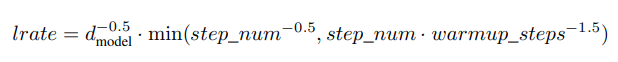

- 초반 warmup_step 동안에는 lr이 0부터 시작해서 선형으로 증가
- warmup이 끝난 후에는 무리함수 곡선으로 감소

In [ ]:
class NoamScheduler:
    def __init__(self, optimizer, d_model, warmup_steps, lr_scale=1):
        self.optimizer = optimizer
        self.curr_step = 0
        self._d_model_factor = lr_scale * math.sqrt(d_model)
        self._warmup_steps_factor = warmup_steps ** (-1.5)
        self.lr_scale = 1
        self.step()

    def step(self):
        self.curr_step += 1
        lr = self.calculate_lr(self.curr_step)
        self.optimizer.param_groups[0]["lr"] = lr

    def calculate_lr(self, curr_step):
        adj_factor = min(curr_step ** (-0.5), curr_step * self._warmup_steps_factor)
        lr = self._d_model_factor * adj_factor
        return lr

    def reset(self):
        self.curr_step = 0
        self.step()

In [ ]:
optimizer = Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9)
warmup_steps = 1000
scheduler = NoamScheduler(optimizer, d_model, warmup_steps)

scheduler.calculate_lr(1)

0.0007155417527999328

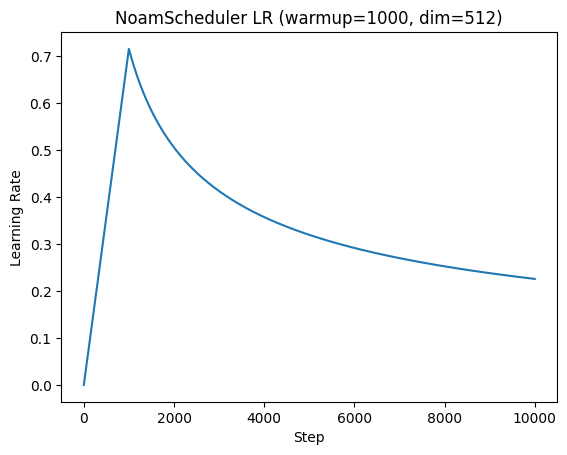

In [ ]:
total_steps = 10_000
lr_per_steps = [scheduler.calculate_lr(s) for s in range(1, total_steps+1)]

plt.title(f"NoamScheduler LR (warmup={warmup_steps}, dim={d_model})")
plt.plot(range(total_steps), lr_per_steps)
plt.xlabel("Step")
plt.ylabel("Learning Rate")
plt.show()

# Train

In [ ]:
class TransformerTrainer:
    def __init__(self,
                 model,
                 tokenizer,
                 optimizer,
                 scheduler,
                 tr_loader,
                 val_loader,
                 criteria,
                 checkpoint_dir,
                 device):
        self.model = model
        self.tokenizer = tokenizer
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.tr_loader = tr_loader
        self.val_loader = val_loader
        self.criteria = criteria
        self.checkpoint_dir = checkpoint_dir
        self.device = device
        self.loss_history = { "train": [], "eval": [], }

    def train(self, epochs):
        for i in range(epochs):
            loss_train = self.train_one_epoch()
            loss_eval = self.eval()

            print("Epoch {} / {} Train Loss {} Eval Loss {} Curren LR: {}".format(i+1,
                                                                                epochs,
                                                                                loss_train,
                                                                                loss_eval,
                                                                                self.optimizer.param_groups[0]["lr"]))

            self.save_histroy(loss_train, loss_eval)

            if (i + 1) % 10 == 0:
                self.save_model(i+1)
                print("Epoch {}: Model saved!".format(i+1))

    def train_one_epoch(self):
        self.model.train()
        total_loss = 0
        with tqdm(self.tr_loader, leave=False) as pbar:
            pbar.set_description("Training")
            for src, tgt in pbar:
                tgt = [self.tokenizer.eos_token + " " + s for s in tgt]

                encoded_src = self.tokenizer(src, padding=True, truncation=True, max_length=model.max_len, return_tensors="pt").input_ids.to(self.device)
                encoded_tgt = self.tokenizer(tgt, padding=True, truncation=True, max_length=model.max_len, return_tensors="pt").input_ids.to(self.device)
                one_hot_tgt = F.one_hot(encoded_tgt[:, 1:], self.tokenizer.vocab_size).type(torch.FloatTensor).to(self.device)

                pred = self.model(encoded_src, encoded_tgt[:, :-1])
                loss = self.criteria(pred, one_hot_tgt)

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                self.scheduler.step()

                total_loss += loss.item()
                pbar.set_postfix(loss=loss.item(), next_lr=self.optimizer.param_groups[0]["lr"])

        return total_loss / len(self.tr_loader)

    def eval(self):
        self.model.eval()
        total_loss = 0
        with tqdm(self.val_loader, leave=False) as pbar:
            pbar.set_description("Evalutation")
            with torch.no_grad():
                for src, tgt in pbar:
                    tgt = [self.tokenizer.eos_token + " " + s for s in tgt]

                    encoded_src = self.tokenizer(src, padding=True, truncation=True, max_length=model.max_len, return_tensors="pt").input_ids.to(self.device)
                    encoded_tgt = self.tokenizer(tgt, padding=True, truncation=True, max_length=model.max_len, return_tensors="pt").input_ids.to(self.device)
                    one_hot_tgt = F.one_hot(encoded_tgt[:, 1:], self.tokenizer.vocab_size).type(torch.FloatTensor).to(self.device)

                    pred = self.model(encoded_src, encoded_tgt[:, :-1])
                    loss = self.criteria(pred, one_hot_tgt)

                    total_loss += loss.item()
                    pbar.set_postfix(loss=loss.item())

        return total_loss / len(self.val_loader)

    def save_histroy(self, loss_train, loss_eval):
        self.loss_history["train"].append(loss_train)
        self.loss_history["eval"].append(loss_eval)

    def save_model(self, epoch):
        torch.save({
            "model": model.state_dict(),
            "optimizer": self.optimizer.state_dict(),
            "scheduler": self.scheduler,
            "epoch": epoch,
            "loss_history": self.loss_history,
         }, self.checkpoint_dir + "/base_{}.pt".format(epoch))

## Train Configuration

In [ ]:
### Model Config ###
vocab_size = tokenizer.vocab_size
pad_idx = tokenizer.pad_token_id
num_head = 8
num_block = 6
max_len = 512
d_model = 512
d_k = 64
d_v = 64
d_ff = 2048
dropout = 0.1
device = "cuda" if torch.cuda.is_available() else "cpu"

### Optimizer(Adam) Config ###
lr = 0
betas = (0.9, 0.98)
eps = 1e-9 # L2 norm regularization hyper-parameter

### Trainer Params ###
batch_size = 20
label_smoothing = 0.1 # for label smoothing
checkpoint_dir = dir
epochs = 20

### Scheduler Config ###
warmup_steps = 1000
lr_scale = 1

model = Transformer(vocab_size, pad_idx, max_len, num_block, num_head, d_model, d_k, d_v, d_ff, dropout, device).to(device)
optimizer = Adam(model.parameters(), lr=lr, betas=betas, eps=eps)
scheduler = NoamScheduler(optimizer, d_model, warmup_steps, lr_scale)
tr_loader = DataLoader(tr_ds, batch_size=batch_size)
val_loader = DataLoader(val_ds, batch_size=batch_size)
criteria = nn.CrossEntropyLoss(label_smoothing=label_smoothing) # SoftmaxCrossEntropyLoss에 label smoothing 적용.

trainer = TransformerTrainer(model, tokenizer, optimizer, scheduler, tr_loader, val_loader, criteria, checkpoint_dir, device)

In [ ]:
trainer.train(epochs) # Colab pro 써도 학습이 쉽지 않다... 데이터 80만개 학습이 목표였지만 비용 이슈로 1만개 학습

Epoch 1 / 20 Train Loss 0.3921301113963127 Eval Loss 0.3902536177635193 Curren LR: 0.3584864181527663


Epoch 2 / 20 Train Loss 0.3965160990357399 Eval Loss 0.39025362074375153 Curren LR: 0.7151842500282788


Epoch 3 / 20 Train Loss 0.39221398276090624 Eval Loss 0.3902536249160767 Curren LR: 0.5840427461927877


Epoch 4 / 20 Train Loss 0.3925469372868538 Eval Loss 0.390253626704216 Curren LR: 0.5058379819349433


Epoch 5 / 20 Train Loss 0.39225951993465424 Eval Loss 0.39025362372398376 Curren LR: 0.4524578574352512


Epoch 6 / 20 Train Loss 0.3927162620425224 Eval Loss 0.39025362074375153 Curren LR: 0.41304938776667116


Epoch 7 / 20 Train Loss 0.39220386093854903 Eval Loss 0.3902536249160767 Curren LR: 0.3824185276704399


Epoch 8 / 20 Train Loss 0.39210847413539884 Eval Loss 0.39025362610816955 Curren LR: 0.3577261634239247


Epoch 9 / 20 Train Loss 0.39217204409837725 Eval Loss 0.3902536249160767 Curren LR: 0.33727214448360227


Epoch 10 / 20 Train Loss 0.3921050214767456 Eval Loss 0.39025362372398376 Curren LR: 0.3199680047992001
Epoch 10: Model saved!


Epoch 11 / 20 Train Loss 0.39210562098026275 Eval Loss 0.39025362610816955 Curren LR: 0.30508029524684216


Epoch 12 / 20 Train Loss 0.39209890115261076 Eval Loss 0.3902536219358444 Curren LR: 0.2920943571537912


Epoch 13 / 20 Train Loss 0.39211297219991686 Eval Loss 0.39025361835956573 Curren LR: 0.2806369795485072


Epoch 14 / 20 Train Loss 0.39210288923978803 Eval Loss 0.3902536225318909 Curren LR: 0.27043004577110785


Epoch 15 / 20 Train Loss 0.39210760045051574 Eval Loss 0.39025362133979796 Curren LR: 0.2612614890448118


Epoch 16 / 20 Train Loss 0.39212786799669264 Eval Loss 0.39025362372398376 Curren LR: 0.2529664029073328


Epoch 17 / 20 Train Loss 0.39209419709444043 Eval Loss 0.39025362610816955 Curren LR: 0.24541436071686024


Epoch 18 / 20 Train Loss 0.3921061683893204 Eval Loss 0.3902536243200302 Curren LR: 0.23850066793090643


Epoch 19 / 20 Train Loss 0.39210254776477815 Eval Loss 0.3902536273002625 Curren LR: 0.232140182452371


Epoch 20 / 20 Train Loss 0.3920946545004845 Eval Loss 0.3902536219358444 Curren LR: 0.22626285711965366
Epoch 20: Model saved!


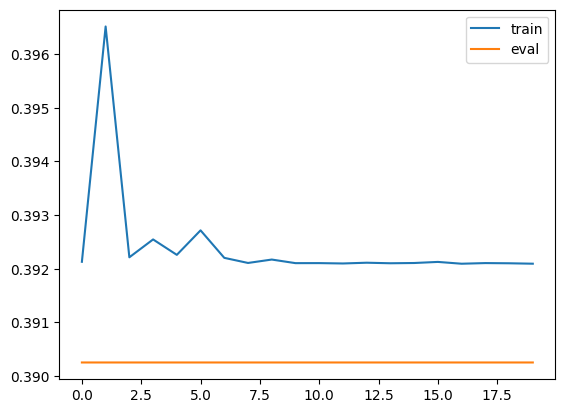

In [ ]:
plt.title("Loss History")
for key in trainer.loss_history:
    plt.plot(range(len(trainer.loss_history[key])), trainer.loss_history[key], label=key)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig(result_dir + "loss.png")
plt.show()

# Test

In [ ]:
def translate(model: Transformer, tokenizer, src: str, extra_token_len: int, device):
    '''
    Transformer 번역 함수
    :Args:
        :model: Transformer
        :src: 번역할 text
    :Return:
        :translated: 번역 결과
    '''
    model.eval()
    with torch.no_grad():
        encoded_src = tokenizer(src, return_tensors="pt").input_ids.to(device)
        enc_mask = model.make_enc_mask(encoded_src)
        enc_out = model.encode(encoded_src, enc_mask)

        pred = tokenizer(tokenizer.eos_token, return_tensors="pt", add_special_tokens=False).input_ids.to(device)
        max_len = encoded_src.shape[1] + extra_token_len

        for _ in range(max_len):
            dec_mask = model.make_dec_mask(pred)
            enc_dec_mask = model.make_enc_dec_mask(encoded_src, pred)
            dec_out = model.decode(pred, enc_out, dec_mask, enc_dec_mask)
            pred_token = dec_out.argmax(-1)[:, -1].unsqueeze(0)
            pred = torch.cat([pred, pred_token], dim=-1).to(device)

            if pred_token.item() == tokenizer.eos_token_id:
                break

        translated = tokenizer.decode(pred[0])

    return translated

In [ ]:
src = ""
extra_token_len = 50
translate(model, tokenizer, src, extra_token_len, device)

'</s>'

In [ ]:
def evaluate(model, tokenizer, criteria, eval_loader, device):
    model.eval()
    total_loss = 0
    with tqdm(eval_loader) as pbar:
        pbar.set_description("Evalutaion")
        with torch.no_grad():
            for src, tgt in pbar:
                tgt = [tokenizer.eos_token + " " + s for s in tgt]

                encoded_src = tokenizer(src, padding=True, truncation=True, max_length=model.max_len, return_tensors="pt").input_ids.to(device)
                encoded_tgt = tokenizer(tgt, padding=True, truncation=True, max_length=model.max_len, return_tensors="pt").input_ids.to(device)
                one_hot_tgt = F.one_hot(encoded_tgt[:, 1:], tokenizer.vocab_size).type(torch.FloatTensor).to(device)

                pred = model(encoded_src, encoded_tgt[:, :-1])
                loss = criteria(pred, one_hot_tgt)

                total_loss += loss.item()

                pbar.set_postfix(loss=loss.item())

    return total_loss / len(eval_loader)

In [ ]:
test_loader = DataLoader(test_ds, batch_size=batch_size)
evaluate(model, tokenizer, criteria, test_loader, device)

Evalutaion: 100%|██████████| 50/50 [00:28<00:00,  1.77it/s, loss=0.404]


0.3935285896062851

# Metric: BLEU